In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # from 0~255 to 0~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # from 0~1 to -1~1 (v - mean) / std
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = DataLoader(testset, batch_size=16, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(trainset), len(testset)

(50000, 10000)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [25]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )

    def forward(self, x):
        x = self.feature_extraction(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)

        return x

In [26]:
net = Net().to(device)

In [27]:
print(net)

Net(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [29]:
loss_ = []
n = len(train_loader)
net.train()

for epoch in range(10):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, labels = data[0].to(device), data[1].to(device)
        preds = net(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_.append(running_loss/n)
    print(f'[{epoch+1}] loss: {running_loss/n:.3f}')

print('Finished Training')

[1] loss: 1.511
[2] loss: 1.255
[3] loss: 1.148
[4] loss: 1.068
[5] loss: 1.011
[6] loss: 0.960
[7] loss: 0.917
[8] loss: 0.881
[9] loss: 0.850
[10] loss: 0.817
Finished Training


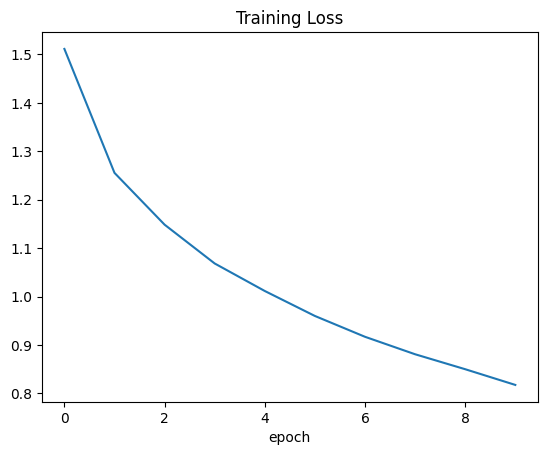

In [30]:
plt.plot(loss_)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
PATH = 'models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [32]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [33]:
correct = 0
total = 0

with torch.inference_mode():
    net.eval()
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, pred = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (pred == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 63.61 %
